# Home Credit Default Risk

Can you predict how capable each applicant is of repaying a loan?

Many people struggle to get loans due to **insufficient or non-existent credit histories**. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the **unbanked population by providing a positive and safe borrowing experience**. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

**Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.**

# Dataset

In [1]:
# #Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
import pandas_profiling

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time
import requests
import datetime

import missingno as msno
import math
import sys
import gc
import os

# #sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

# #sklearn - metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# #XGBoost & LightGBM
import xgboost as xgb
import lightgbm as lgb

# #Missing value imputation
from fancyimpute import KNN, MICE

c:\users\karti\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Dictionary

In [2]:
!ls -l ../data/

total 2621364
-rw-r--r-- 1 karti 197609  26567651 May 17 18:06 application_test.csv
-rw-r--r-- 1 karti 197609 166133370 May 17 18:06 application_train.csv
-rw-r--r-- 1 karti 197609 170016717 May 17 18:08 bureau.csv
-rw-r--r-- 1 karti 197609 375592889 May 17 18:08 bureau_balance.csv
-rw-r--r-- 1 karti 197609 424582605 May 17 18:10 credit_card_balance.csv
-rw-r--r-- 1 karti 197609     37383 May 20 19:55 HomeCredit_columns_description.csv
-rw-r--r-- 1 karti 197609 723118349 May 17 18:13 installments_payments.csv
-rw-r--r-- 1 karti 197609 392703158 May 17 18:14 POS_CASH_balance.csv
-rw-r--r-- 1 karti 197609 404973293 May 17 18:15 previous_application.csv
-rw-r--r-- 1 karti 197609    536202 May 17 18:06 sample_submission.csv


- application_{train|test}.csv

This is the main table, broken into two files for Train (**with TARGET**) and Test (without TARGET).
Static data for all applications. **One row represents one loan in our data sample.**

- bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

- installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

# Data Pre-processing

In [3]:
df_application_train = pd.read_csv("../data/application_train.csv")

In [4]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_application_test = pd.read_csv("../data/application_test.csv")

In [6]:
df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Missing Value Imputation

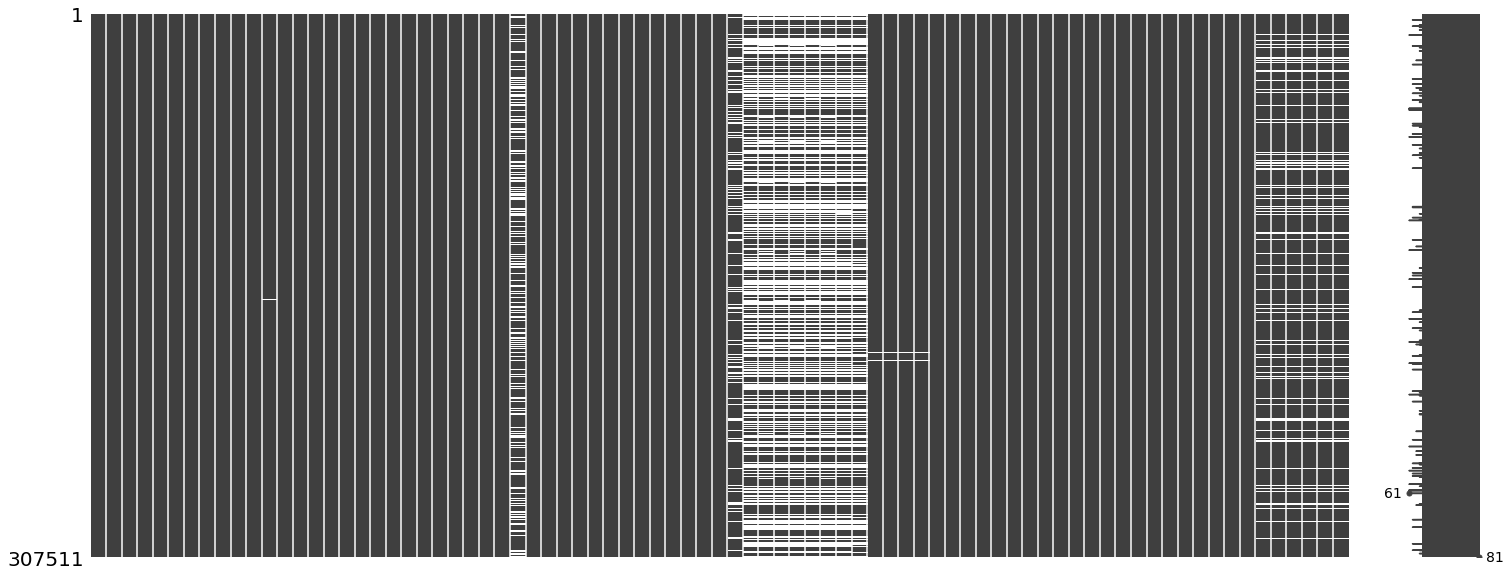

In [92]:
msno.matrix(df_application_train)

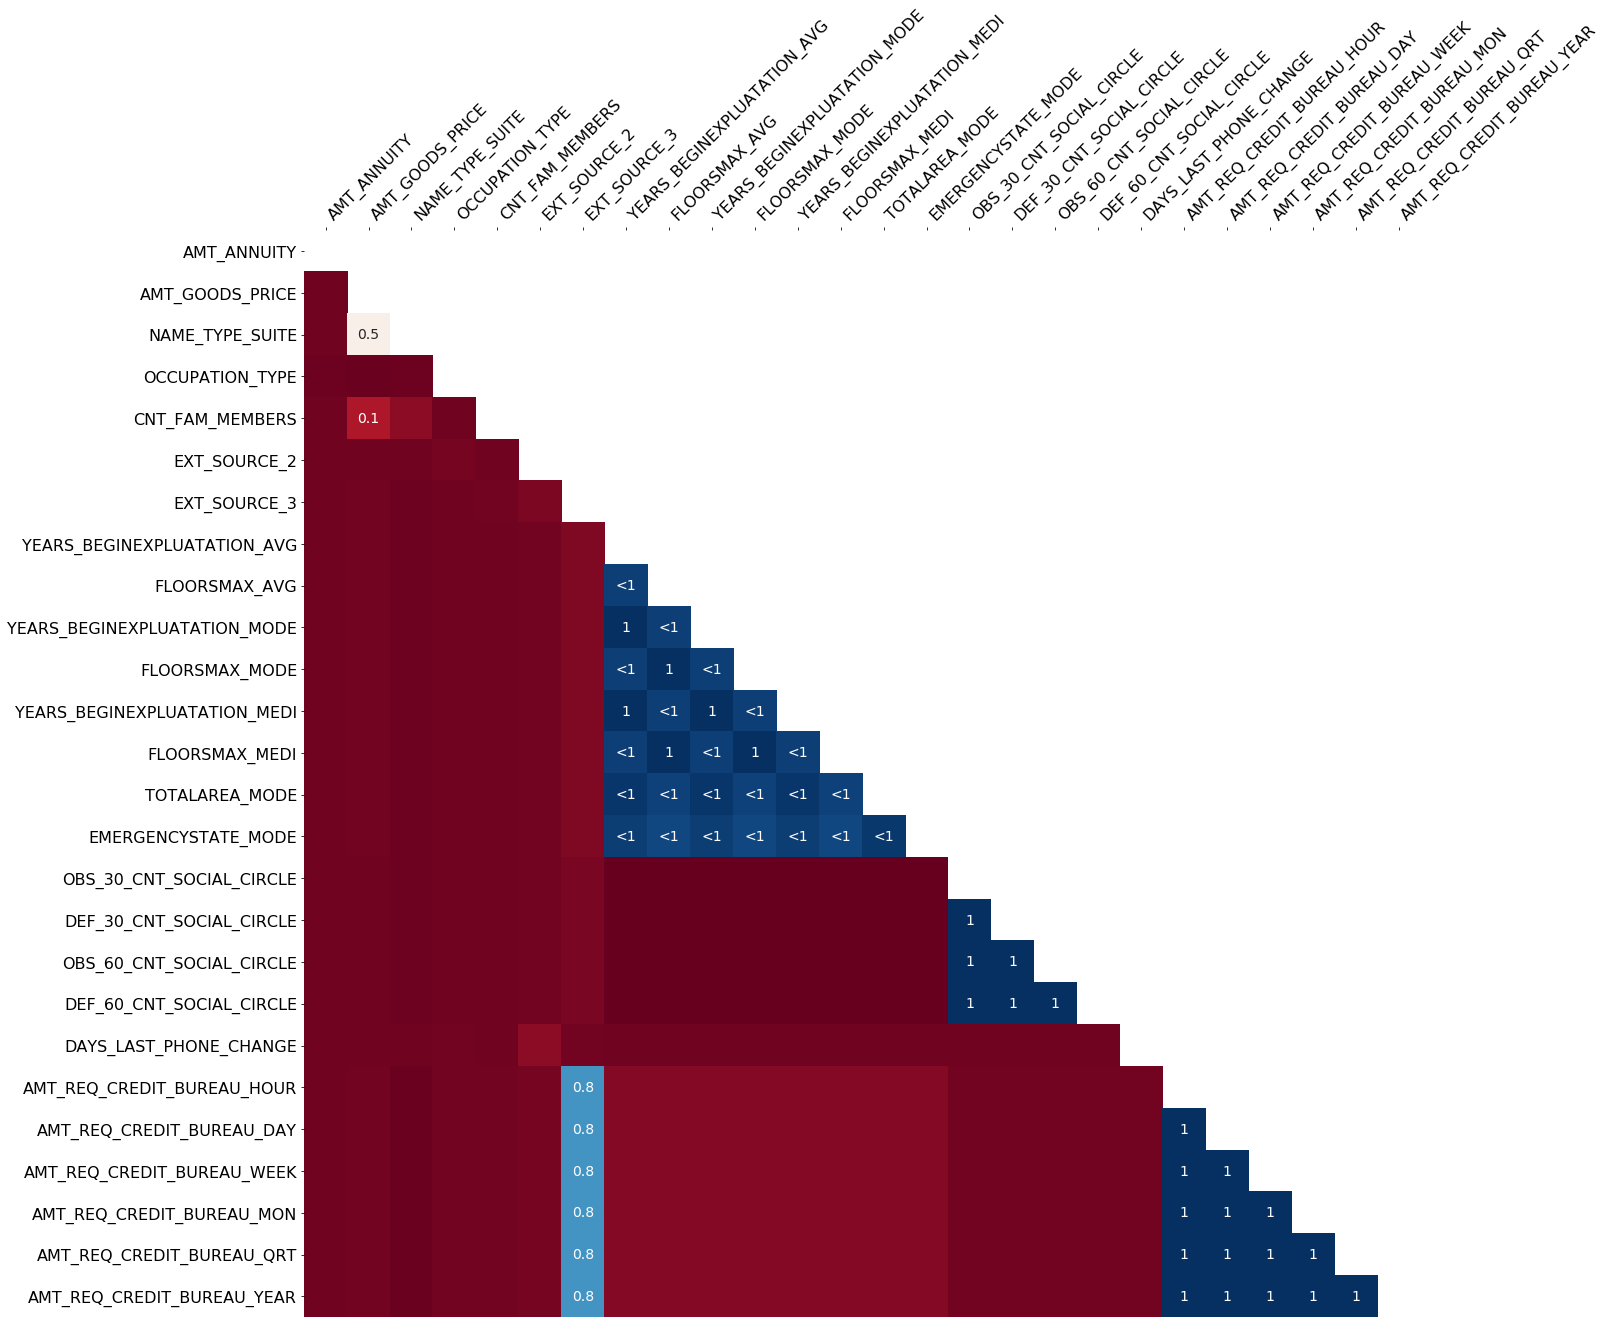

In [95]:
msno.heatmap(df_application_train, figsize=(20,20))

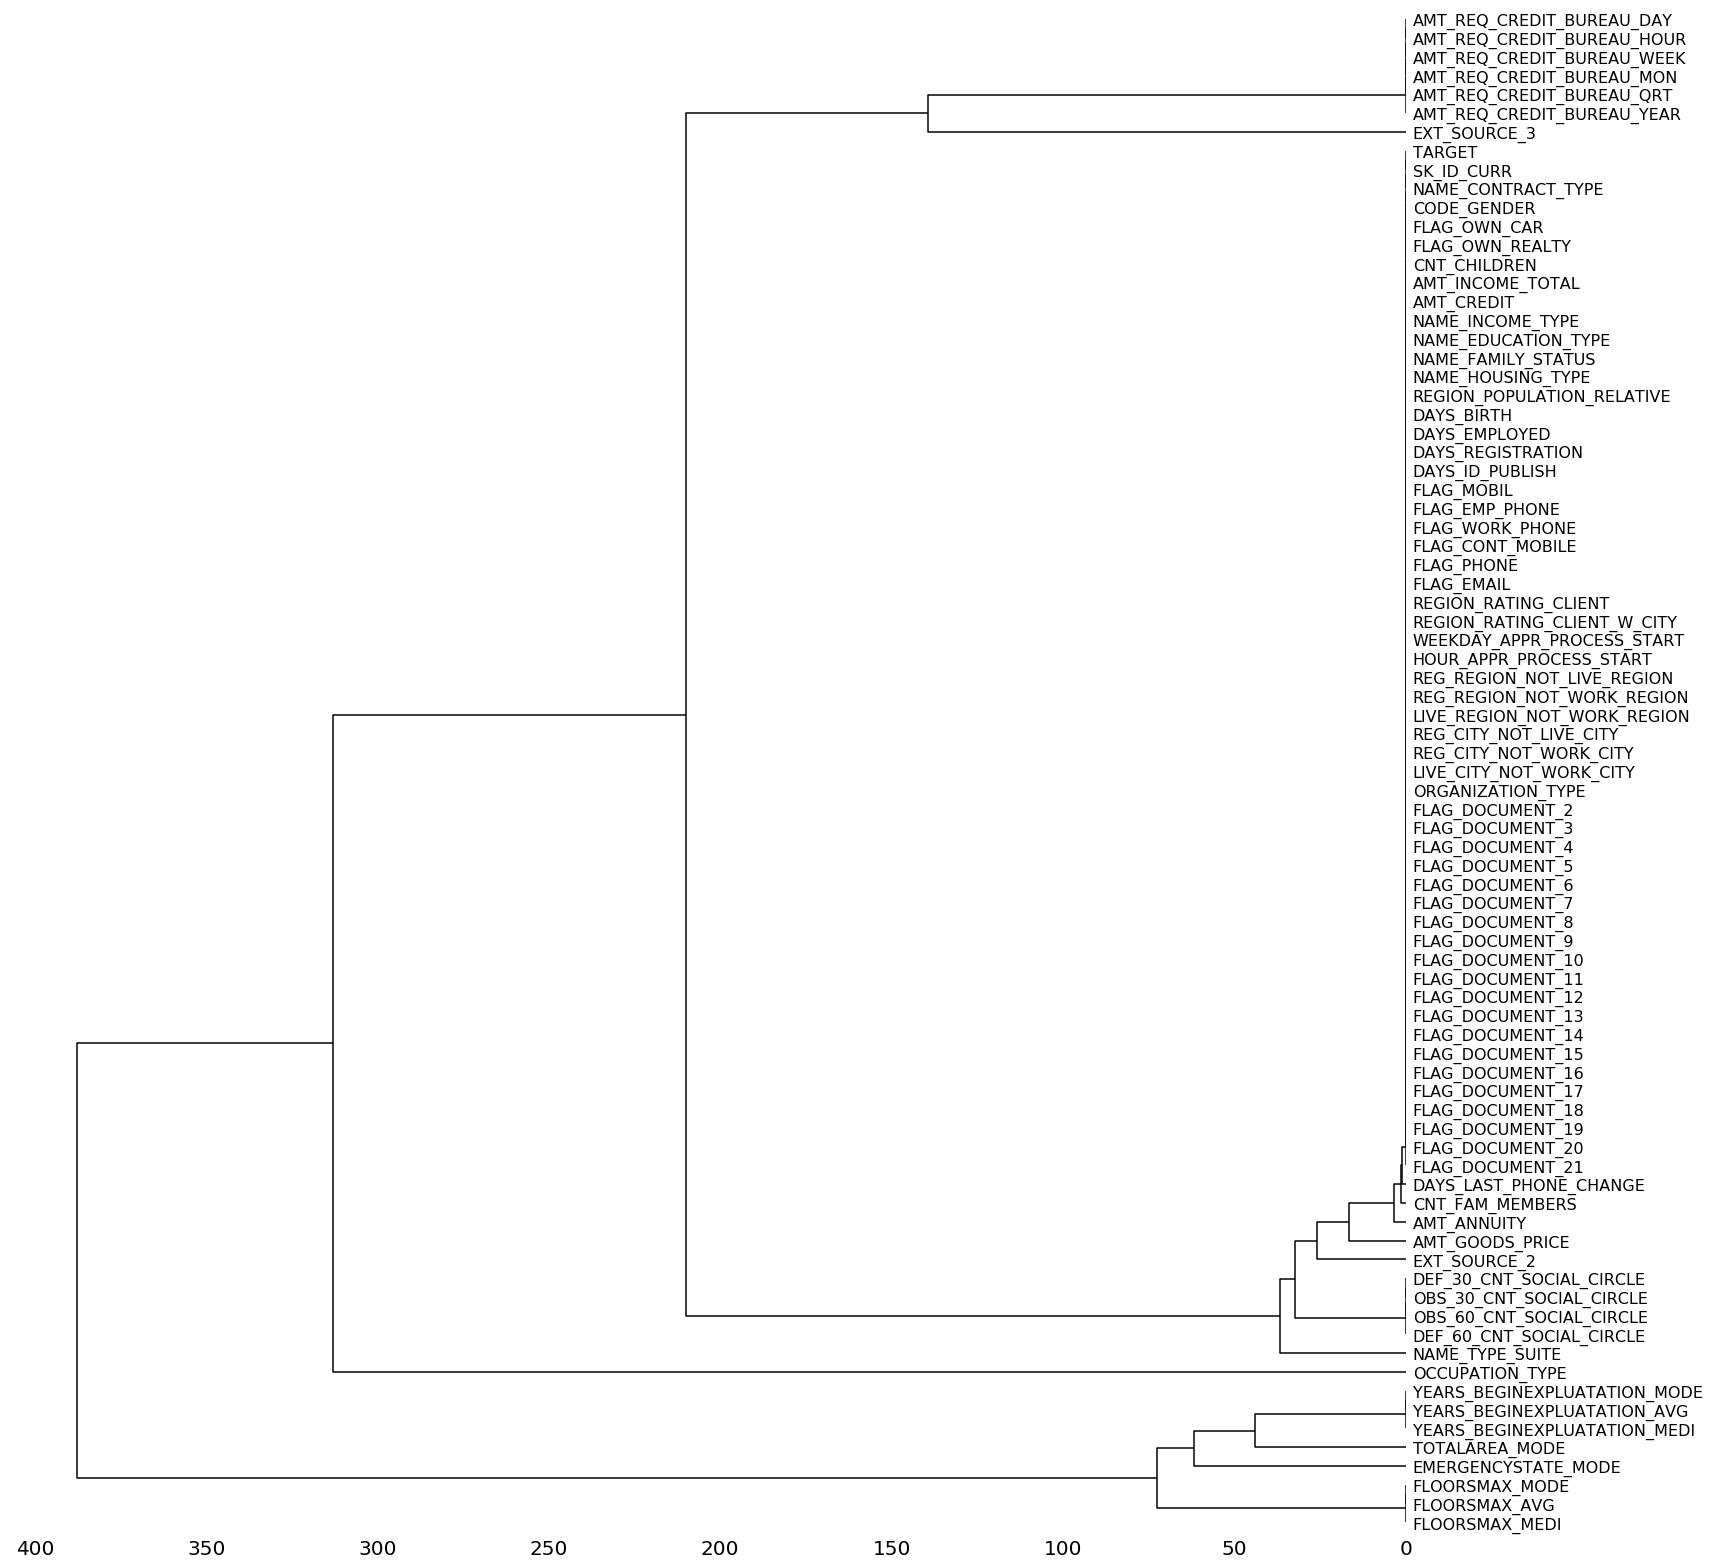

In [94]:
msno.dendrogram(df_application_train)

In [50]:
def f_missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [56]:
df_train_missing_info = f_missing_data(df_application_train)
df_train_missing_info

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [65]:
df_train_missing_info[df_train_missing_info["Percent"] >= 50]

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [108]:
df_application_train.shape, df_application_test.shape

((307511, 122), (48744, 121))

In [109]:
df_application_train.isnull().sum(axis = 0).sum(), df_application_test.isnull().sum(axis = 0).sum()

(9152465, 1404419)

In [110]:
# #Categorical Encoding

# df_application_train.dtypes[df_application_train.dtypes == object]
# arr_categorical_columns = ['NAME_CONTRACT_TYPE',
#                            'CODE_GENDER',
#                            'FLAG_OWN_CAR',
#                            'FLAG_OWN_REALTY',
#                            'NAME_TYPE_SUITE',
#                            'NAME_INCOME_TYPE',
#                            'NAME_EDUCATION_TYPE',
#                            'NAME_FAMILY_STATUS',
#                            'NAME_HOUSING_TYPE',
#                            'OCCUPATION_TYPE',
#                            'WEEKDAY_APPR_PROCESS_START',
#                            'ORGANIZATION_TYPE',
#                            'FONDKAPREMONT_MODE',
#                            'HOUSETYPE_MODE',
#                            'WALLSMATERIAL_MODE',
#                            'EMERGENCYSTATE_MODE']

arr_categorical_columns = df_application_train.select_dtypes(['object']).columns
for var_col in arr_categorical_columns:
    df_application_train[var_col] = df_application_train[var_col].astype('category').cat.codes
    df_application_test[var_col] = df_application_test[var_col].astype('category').cat.codes

In [111]:
df_application_train_imputed = MICE().complete(df_application_train)

[MICE] Completing matrix with shape (307511, 122)
[MICE] Starting imputation round 1/110, elapsed time 0.623
[MICE] Starting imputation round 2/110, elapsed time 67.151
[MICE] Starting imputation round 3/110, elapsed time 122.910
[MICE] Starting imputation round 4/110, elapsed time 176.534
[MICE] Starting imputation round 5/110, elapsed time 231.811
[MICE] Starting imputation round 6/110, elapsed time 286.874
[MICE] Starting imputation round 7/110, elapsed time 343.449
[MICE] Starting imputation round 8/110, elapsed time 399.471
[MICE] Starting imputation round 9/110, elapsed time 452.007
[MICE] Starting imputation round 10/110, elapsed time 505.334
[MICE] Starting imputation round 11/110, elapsed time 559.458
[MICE] Starting imputation round 12/110, elapsed time 613.370
[MICE] Starting imputation round 13/110, elapsed time 666.734
[MICE] Starting imputation round 14/110, elapsed time 722.126
[MICE] Starting imputation round 15/110, elapsed time 792.194
[MICE] Starting imputation round

In [112]:
df_application_train_imputed = pd.DataFrame(df_application_train_imputed, columns=df_application_train.columns)

In [113]:
df_application_train_imputed.isnull().sum(axis = 0).sum(), df_application_test.isnull().sum(axis = 0).sum()

(0, 1285385)

In [114]:
df_application_train_imputed.to_csv("../transformed_data/application_train_imputed.csv")

In [7]:
arr_categorical_columns = df_application_test.select_dtypes(['object']).columns
for var_col in arr_categorical_columns:
    df_application_train[var_col] = df_application_train[var_col].astype('category').cat.codes
    df_application_test[var_col] = df_application_test[var_col].astype('category').cat.codes

In [8]:
df_application_test_imputed = MICE().complete(df_application_test)

[MICE] Completing matrix with shape (48744, 121)
[MICE] Starting imputation round 1/110, elapsed time 0.189
[MICE] Starting imputation round 2/110, elapsed time 13.575
[MICE] Starting imputation round 3/110, elapsed time 27.160
[MICE] Starting imputation round 4/110, elapsed time 40.513
[MICE] Starting imputation round 5/110, elapsed time 54.345
[MICE] Starting imputation round 6/110, elapsed time 69.215
[MICE] Starting imputation round 7/110, elapsed time 83.328
[MICE] Starting imputation round 8/110, elapsed time 97.318
[MICE] Starting imputation round 9/110, elapsed time 111.329
[MICE] Starting imputation round 10/110, elapsed time 125.506
[MICE] Starting imputation round 11/110, elapsed time 140.127
[MICE] Starting imputation round 12/110, elapsed time 155.050
[MICE] Starting imputation round 13/110, elapsed time 169.405
[MICE] Starting imputation round 14/110, elapsed time 183.654
[MICE] Starting imputation round 15/110, elapsed time 197.606
[MICE] Starting imputation round 16/110

In [9]:
df_application_test_imputed = pd.DataFrame(df_application_test_imputed, columns=df_application_test.columns)

In [11]:
df_application_test_imputed.isnull().sum(axis = 0).sum()

0

In [12]:
df_application_test_imputed.to_csv("../transformed_data/application_test_imputed.csv")

In [119]:
df_application_train.shape, df_application_test.shape

((307511, 122), (48744, 121))

In [120]:
df_application_train_imputed.shape, df_application_test_imputed.shape

((307511, 122), (48744, 121))

# Model Building

## Encode categorical columns

## Train-Validation Split

In [122]:
input_columns = df_application_train_imputed.columns
input_columns = input_columns[input_columns != 'TARGET']
target_column = 'TARGET'

X = df_application_train_imputed[input_columns]
y = df_application_train[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [123]:
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_eval = lgb.Dataset(data=X_test, label=y_test)

In [130]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'learning_rate': 0.2,
        'num_leaves': 23,
        'min_data_in_leaf': 1,
        'num_iteration': 200,
        'verbose': 0
}

In [131]:
model_1 = lgb.train(params,
            lgb_train,
            num_boost_round=100,
            valid_sets=lgb_eval,
            early_stopping_rounds=50)

c:\users\karti\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.701455
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.712109
[3]	valid_0's auc: 0.717744
[4]	valid_0's auc: 0.718411
[5]	valid_0's auc: 0.720219
[6]	valid_0's auc: 0.72165
[7]	valid_0's auc: 0.723682
[8]	valid_0's auc: 0.726749
[9]	valid_0's auc: 0.727799
[10]	valid_0's auc: 0.729219
[11]	valid_0's auc: 0.729661
[12]	valid_0's auc: 0.730758
[13]	valid_0's auc: 0.732359
[14]	valid_0's auc: 0.733787
[15]	valid_0's auc: 0.73597
[16]	valid_0's auc: 0.737596
[17]	valid_0's auc: 0.739037
[18]	valid_0's auc: 0.739976
[19]	valid_0's auc: 0.74164
[20]	valid_0's auc: 0.742909
[21]	valid_0's auc: 0.743872
[22]	valid_0's auc: 0.744697
[23]	valid_0's auc: 0.745389
[24]	valid_0's auc: 0.747589
[25]	valid_0's auc: 0.748039
[26]	valid_0's auc: 0.74839
[27]	valid_0's auc: 0.748821
[28]	valid_0's auc: 0.749723
[29]	valid_0's auc: 0.750215
[30]	valid_0's auc: 0.75096
[31]	valid_0's auc: 0.751301
[32]	valid_0's auc: 0.751576
[33]	valid_0's auc: 0.75

In [132]:
df_predict = model_1.predict(df_application_test, num_iteration=model_1.best_iteration)

In [133]:
df_predict

array([0.06747816, 0.11561836, 0.05682496, ..., 0.04586294, 0.06832009,
       0.35849376])

In [134]:
submission = pd.DataFrame()
submission["SK_ID_CURR"] =  df_application_test["SK_ID_CURR"]
submission["TARGET"] =  df_predict

submission.to_csv("../submissions/model_1_lightgbmstarter_missingdata_MICE.csv", index=False)

In [135]:
submission.shape

(48744, 2)